In [266]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [267]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [268]:
y.shape, tx.shape

((10000,), (10000, 2))

In [269]:
tx[0:5,:]

array([[ 1.        ,  1.94406149],
       [ 1.        ,  0.62753668],
       [ 1.        ,  2.01244346],
       [ 1.        ,  1.39406046],
       [ 1.        ,  0.9134207 ]])

# 1 Computing the Cost Function

Fill in the `compute_loss` function below:
<a id='compute_loss'></a>


In [270]:
tx.dot([1, 2])

array([ 4.88812299,  2.25507336,  5.02488691, ..., -0.29937583,
        2.38624937, -1.29941662])

In [271]:
def compute_loss(y, tx, w, cost = "mse"):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    N = tx.shape[0]
    error_vec = y - tx.dot(w)
    if (cost == "mse"):
        loss = (1 / (2*N)) * np.linalg.norm(error_vec)**2
    elif (cost == "mae"):
        loss = (1 / N) * np.sum(np.abs(error_vec))
    else:
        print("Invalid cost argument in compute_loss")
        raise NotImplementedError
    return loss
    


In [272]:
w = np.array([1, 2])
compute_loss(y, tx, w)

2694.4833658870839

# 2 Grid Search

Fill in the function `grid_search()` below:

In [273]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    for i in range(len(w0)):
        for j in range(len(w1)):
            losses[i, j] = compute_loss(y, tx, np.array([w0[i], w1[j]]))
    
    argmin_index = np.argmin(losses);
    best_i = argmin_index % len(w0)
    best_j = argmin_index // len(w1)
    print(best_i, best_j)
    
    #raise NotImplementedError
    return losses, w0[best_i], w1[best_j]

In [274]:
grid_search(y, tx, [1, 2], [3, 4])

1 1


(array([[ 2683.50365345,  2673.52394102],
        [ 2611.70973145,  2601.73001902]]), 2, 4)

Let us play with the grid search demo now!

54 57
Grid Search: loss*=15.55870336860953, w0*=72.72727272727272, w1*=13.636363636363626, execution time=0.400 seconds


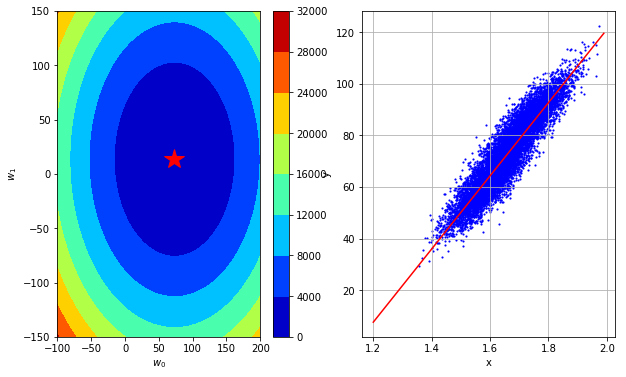

In [275]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=100)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)[0]

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# 3 Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [335]:
def compute_gradient(y, tx, w, cost = "mse"):
    """Compute the gradient."""
    N = tx.shape[0];
    error_vec = y - tx.dot(w)
    if (cost == "mse"):
        grad = -(1/N) * np.transpose(tx).dot(error_vec)
    elif (cost == "mae"):
        sub_grad = [0 if error_vec[i] == 0 else error_vec[i] / np.abs(error_vec[i]) for i in range(N)]
        grad = -(1 / N) * np.transpose(tx).dot(sub_grad)
    else:
        print("Invalid argument in compute_gradient function.")
        raise NotImplementedError
    return grad
    
    


In [336]:
compute_gradient(y, tx, np.array([73.2732732732, 13.363363363363362]))

array([-0.02064873, -0.11634907])

Please fill in the functions `gradient_descent` below:

In [278]:
# Be careful, gamma of 2 for MSE doesn't converge
def gradient_descent(y, tx, initial_w, max_iters, gamma, cost ="mse", tol = 1e-6, thresh_test_conv = 10):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    initial_loss = compute_loss(y, tx, initial_w, cost)
    losses = [initial_loss]
    w = initial_w
    test_conv = 0
    dist_succ_w = tol + 1
    n_iter = 0;
    while (n_iter < max_iters and dist_succ_w > tol):
        grad = compute_gradient(y, tx, w, cost)
        loss = compute_loss(y, tx, w, cost)
        
        # Test of convergence, test_conv counts the number of consecutive iterations for which loss has increased
        if (loss > losses[n_iter]):
            test_conv += 1
            if (test_conv == thresh_test_conv):
                print("Stopped computing because 10 consecutive iterations have involved an increase in loss.")
                return losses, ws
        else:
            test_conv = 0
        
        # updating w
        w = w - gamma * grad
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
        
        # update distance between two successive w
        dist_succ_w = np.linalg.norm(ws[len(ws)-1] - ws[len(ws)-2])
        
        # updat niter: number of iterations
        n_iter += 1

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [279]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2792.2367127591665, w0=51.30574540147352, w1=9.435798704492393
Gradient Descent(1/49): loss=265.302462108962, w0=66.69746902191565, w1=12.266538315840034
Gradient Descent(2/49): loss=37.878379550441615, w0=71.31498610804833, w1=13.115760199244338
Gradient Descent(3/49): loss=17.4102121201745, w0=72.70024123388814, w1=13.370526764265632
Gradient Descent(4/49): loss=15.568077051450459, w0=73.11581777164008, w1=13.446956733772023
Gradient Descent(5/49): loss=15.402284895265295, w0=73.24049073296567, w1=13.469885724623941
Gradient Descent(6/49): loss=15.387363601208634, w0=73.27789262136332, w1=13.476764421879517
Gradient Descent(7/49): loss=15.386020684743531, w0=73.28911318788263, w1=13.478828031056189
Gradient Descent(8/49): loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919
Gradient Descent(9/49): loss=15.385888944638307, w0=73.29348920882516, w1=13.47963283863509
Gradient Descent(10/49): loss=15.385887965652199, w0=73.29379216412119, w1=13

In [280]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

A Jupyter Widget

<function __main__.plot_figure>

# 4 Stochastic gradient descent

In [281]:
batched = batch_iter(y, tx, 5)
count = 0
[print(i, count) for i in batched]

(array([ 83.74867648,  89.33142852,  77.81408506,  93.29301816,  65.66720385]), array([[ 1.        ,  0.35366296],
       [ 1.        ,  1.14241028],
       [ 1.        ,  0.84655726],
       [ 1.        ,  1.49494201],
       [ 1.        , -0.98265094]])) 0


[None]

In [338]:
def compute_stoch_gradient(y, tx, w, batch_size=1, cost ="mse"):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    batched = [x for x in batch_iter(y, tx, batch_size)][0]
    y_b = batched[0]
    tx_b = batched[1]
    error_vec = y_b - tx_b.dot(w)

    if (cost == "mse"):
        stoch_grad = (-2 / batch_size) * np.transpose(tx_b).dot(error_vec)
    elif (cost == "mae"):
        sub_grad_abs = [0 if error_vec[i] == 0 else error_vec[i] / np.abs(error_vec[i]) for i in range(batch_size)]
        stoch_grad = -(1 / batch_size) * np.transpose(tx_b).dot(sub_grad_abs)
    else:
        print("Invalid cost argument in compute_stoch_gradient")
        raise NotImplementedError
    
    return stoch_grad
    


def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma, cost = "mse", tol = 1e-6, thresh_test_conv = 100):
    """Stochastic gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    initial_loss = compute_loss(y, tx, initial_w, cost)
    losses = [initial_loss]
    w = initial_w
    test_conv = 0
    dist_succ_w = tol + 1
    n_iter = 0
    while (n_iter < max_iters and dist_succ_w > tol):
        stoch_grad = compute_stoch_gradient(y, tx, w, batch_size, cost)
        loss = compute_loss(y, tx, w, cost)
        
        # Test of convergence, test_conv counts the number of consecutive iterations for which loss has increased
        if (loss > losses[n_iter]):
            test_conv += 1
            if (test_conv == thresh_test_conv):
                print("Stopped computing because 10 consecutive iterations have involved an increase in loss.")
                return losses, ws
        else:
            test_conv = 0
        
        # updating w
        w = w - gamma * stoch_grad
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
        
        # computing distance between new w and former one
        dist_succ_w = np.linalg.norm(ws[len(ws)-1] - ws[len(ws)-2])
        
        # updating the number of iteration
        n_iter += 1

    return losses, ws

In [339]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2792.2367127591665, w0=10.969552454507351, w1=-8.12896363005467
Gradient Descent(1/49): loss=2191.0168482635945, w0=21.36457466532592, w1=-12.632962934819897
Gradient Descent(2/49): loss=1704.6503527652737, w0=30.76059797527641, w1=-12.141148392477932
Gradient Descent(3/49): loss=1248.1419690246496, w0=39.03384238257483, w1=-9.514928781095367
Gradient Descent(4/49): loss=866.6391779653322, w0=43.795972161750356, w1=-11.196197085536518
Gradient Descent(5/49): loss=754.9006655934555, w0=40.35961513041557, w1=-4.598301477175336
Gradient Descent(6/49): loss=721.1274659323443, w0=45.18849039274075, w1=-5.482762293178483
Gradient Descent(7/49): loss=590.1312547513558, w0=55.58752924103995, w1=6.653980333497248
Gradient Descent(8/49): loss=195.4393695340488, w0=58.386578248418296, w1=5.1721744052151415
Gradient Descent(9/49): loss=161.00793082219295, w0=62.2870373068123, w1=6.356154925995716
Gradient Descent(10/49): loss=101.3341790085334, w0=67.7046060627738, w1=

In [334]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

A Jupyter Widget

<function __main__.plot_figure>

# 5 Effect of Outliers and MAE Cost Function, and Subgradient Descent

### Exercise 5

Load and plot data containing outliers

In [285]:
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y_out, tx_out = build_model_data(x, weight)

In [286]:
gender = np.append(gender, [0,1])

In [287]:
male_height = height[[x for x in range(len(height)) if gender[x]==0]]
male_weight = weight[[x for x in range(len(height)) if gender[x]==0]]
female_height = height[[x for x in range(len(height)) if gender[x]==1]]
female_weight = weight[[x for x in range(len(height)) if gender[x]==1]]
male_height.shape

(202,)

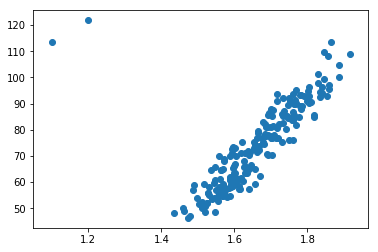

In [288]:
plt.scatter(male_height, male_weight)
plt.scatter(female_height, female_weight)


In [289]:
w_initial = np.array([0, 0])
gamma = 0.7
max_iters = 30
losses_out, w_out = gradient_descent(y_out, tx_out, w_initial, max_iters, gamma)
len(w_out)

Gradient Descent(0/29): loss=2869.835114535852, w0=51.84746409844845, w1=7.724426406192437
Gradient Descent(1/29): loss=318.2821247015958, w0=67.401703327983, w1=10.04175432805012
Gradient Descent(2/29): loss=88.64235561651263, w0=72.06797509684336, w1=10.736952704607411
Gradient Descent(3/29): loss=67.9747763988552, w0=73.46785662750146, w1=10.945512217574597
Gradient Descent(4/29): loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
Gradient Descent(5/29): loss=65.947286877603, w0=74.01381042445813, w1=11.026850427631796
Gradient Descent(6/29): loss=65.93222021235334, w0=74.05160722578589, w1=11.03248153448191
Gradient Descent(7/29): loss=65.93086421248087, w0=74.06294626618423, w1=11.034170866536943
Gradient Descent(8/29): loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
Gradient Descent(9/29): loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038408
Gradient Descent(10/29): loss=65.93073020036945, w0=74.06767464603033, w1=11.034875318003

17

In [290]:
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        losses_out, w_out, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(w_out)))

A Jupyter Widget

<function __main__.plot_figure>

### Exercise 6

Modify the function `compute_loss(y, tx, w)` for the Mean Absolute Error cost function [here](#compute_loss)

In [291]:
def compute_loss_mae(y, tx, w):
    N = tx.shape[0];
    loss = (1 / N) * np.sum(np.abs(y - tx.dot(w)))
    return loss

In [292]:
w_test = np.array([150, 100])

In [293]:
print(compute_loss(y, tx, w_test, cost = "mae"))
print(compute_loss(y, tx, w_test))

94.0970269816
6700.17716894


In [299]:
def compute_gradient_mae(y, tx, w):
    N = tx.shape[0]
    error_vec = y - tx.dot(w)
    sub_grad = [0 if error_vec[i] == 0 else error_vec[i] / np.abs(error_vec[i]) for i in range(N)]
    #print(sub_grad)
    grad = -(1 / N) * np.transpose(tx).dot(sub_grad)
    return grad

In [300]:
compute_gradient_mae(y, tx, w_test)

array([ 0.5956    ,  0.55638512])

In [301]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma, tol = 1e-6, thresh_test_conv = 10):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    initial_loss = compute_loss(y, tx, initial_w, cost = "mae")
    losses = [initial_loss]
    w = initial_w
    test_conv = 0
    dist_succ_w = tol + 1
    n_iter = 0;
    while (n_iter < max_iters and dist_succ_w > tol):
        grad = compute_gradient_mae(y, tx, w)
        loss = compute_loss(y, tx, w, cost = "mae")
        
        # Test of convergence, test_conv counts the number of consecutive iterations for which loss has increased
        if (loss > losses[n_iter]):
            test_conv += 1
            if (test_conv == thresh_test_conv):
                print("Stopped computing because 10 consecutive iterations have involved an increase in loss.")
                return losses, ws
        else:
            test_conv = 0
        
        # updating w
        w = w - gamma * grad
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
        
        # update distance between two successive w
        dist_succ_w = np.linalg.norm(ws[len(ws)-1] - ws[len(ws)-2])
        
        # updat niter: number of iterations
        n_iter += 1

    return losses, ws

In [306]:
w_sub = np.array([0, 0])
gamma = 10
max_iters = 30
losses_sub, w_sub = subgradient_descent(y_out, tx_out, w_sub, max_iters, gamma)
len(w_sub)

Gradient Descent(0/29): loss=74.06780585492638, w0=10.0, w1=1.055261488752624e-14
Gradient Descent(1/29): loss=64.06780585492639, w0=20.0, w1=2.110522977505248e-14
Gradient Descent(2/29): loss=54.067805854926384, w0=30.0, w1=3.1657844662578724e-14
Gradient Descent(3/29): loss=44.067805854926384, w0=40.0, w1=4.221045955010496e-14
Gradient Descent(4/29): loss=34.06780585492638, w0=50.0, w1=5.27630744376312e-14
Gradient Descent(5/29): loss=24.186081863361224, w0=59.40594059405941, w1=0.8868917349265718
Gradient Descent(6/29): loss=16.57390036871177, w0=64.95049504950495, w1=5.294136958480571
Gradient Descent(7/29): loss=11.814643364857497, w0=68.91089108910892, w1=10.409491987173148
Gradient Descent(8/29): loss=7.829766762015699, w0=71.88118811881189, w1=15.166515724701014
Gradient Descent(9/29): loss=5.407776766939082, w0=73.16831683168319, w1=16.16824533672219
Gradient Descent(10/29): loss=5.3321123460897555, w0=72.67326732673268, w1=15.905565298680463
Gradient Descent(11/29): loss=5.31

31

In [312]:
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        losses_sub, w_sub, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(w_sub)))

A Jupyter Widget

<function __main__.plot_figure>

In [319]:
def compute_stoch_gradient_mae(y, tx, w, batch_size=1):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    batched = [x for x in batch_iter(y, tx, batch_size)][0]
    y_b = batched[0]
    tx_b = batched[1]
    
    error_vec = y_b - tx_b.dot(w)
    sub_grad_abs = [0 if error_vec[i] == 0 else error_vec[i] / np.abs(error_vec[i]) for i in range(batch_size)]
    #print("sub_grad_abs: ", sub_grad_abs)
    stoch_grad = -(1 / batch_size) * np.transpose(tx_b).dot(sub_grad_abs)
    
    return stoch_grad
    

In [320]:
def stochastic_subgradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma, tol = 1e-6, thresh_test_conv = 100):
    """Stochastic gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    initial_loss = compute_loss(y, tx, initial_w, cost ="mae")
    losses = [initial_loss]
    w = initial_w
    test_conv = 0
    dist_succ_w = tol + 1
    n_iter = 0
    while (n_iter < max_iters and dist_succ_w > tol):
        stoch_grad = compute_stoch_gradient_mae(y, tx, w, batch_size)
        loss = compute_loss(y, tx, w, cost = "mae")
        
        # Test of convergence, test_conv counts the number of consecutive iterations for which loss has increased
        if (loss > losses[n_iter]):
            test_conv += 1
            if (test_conv == thresh_test_conv):
                print("Stopped computing because 10 consecutive iterations have involved an increase in loss.")
                return losses, ws
        else:
            test_conv = 0
        
        # updating w
        w = w - gamma * stoch_grad
        
        #raise NotImplementedError
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
        
        # computing distance between new w and former one
        dist_succ_w = np.linalg.norm(ws[len(ws)-1] - ws[len(ws)-2])
        
        # updating the number of iteration
        n_iter += 1

    return losses, ws

In [325]:
w_init_sub = np.array([0, 0])
gamma = 2
max_iters = 50
losses_stoch_sub, w_stoch_sub = stochastic_subgradient_descent(y_out, tx_out, w_init_sub, 1, max_iters, gamma)


Gradient Descent(0/49): loss=74.06780585492638, w0=2.0, w1=1.5805883316460383
Gradient Descent(1/49): loss=72.06780585492638, w0=4.0, w1=3.417530328114026
Gradient Descent(2/49): loss=70.06780585492638, w0=6.0, w1=2.276222407009515
Gradient Descent(3/49): loss=68.06780585492639, w0=8.0, w1=0.9103704000777344
Gradient Descent(4/49): loss=66.06780585492639, w0=10.0, w1=-0.8146755141123048
Gradient Descent(5/49): loss=64.06780585492639, w0=12.0, w1=-3.354195011730858
Gradient Descent(6/49): loss=62.067805854926384, w0=14.0, w1=-4.937358080292517
Gradient Descent(7/49): loss=60.067805854926384, w0=16.0, w1=-5.744637563396018
Gradient Descent(8/49): loss=58.067805854926384, w0=18.0, w1=-7.842107057684558
Gradient Descent(9/49): loss=56.067805854926384, w0=20.0, w1=-7.187473651150963
Gradient Descent(10/49): loss=54.067805854926384, w0=22.0, w1=-5.418521091309058
Gradient Descent(11/49): loss=52.067805854926384, w0=24.0, w1=-6.674773677266728
Gradient Descent(12/49): loss=50.067805854926384,

In [326]:
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        losses_stoch_sub, w_stoch_sub, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(w_stoch_sub)))

A Jupyter Widget

<function __main__.plot_figure>